In [1]:
from helper_knn import *

db = pd.read_csv('lc_db_processed.csv').drop(columns = 'Unnamed: 0')

db = pd.concat([db,
                pd.DataFrame(pd.DataFrame(db['pubchem2d'].values).\
                             apply(lambda x: x.str.replace('', ' ').str.strip().str.split(' '), 
                                                                        axis = 1)[0].to_list(),
                   columns = ['pub'+ str(i) for i in range(1,882)])],
               axis = 1)

numerical = ['atom_number', 'bonds_number','Mol', 'MorganDensity', 'LogP',
            'alone_atom_number', 'doubleBond', 'tripleBond', 'ring_number', 'oh_count', 'MeltingPoint', 'WaterSolubility']

categorical = ['obs_duration_mean',
               'conc1_type', 'exposure_type', 'control_type', 'media_type',
               'application_freq_unit', 'species', 'class', 'tax_order', 'family', 'genus']
db.drop(columns = categorical, inplace = True)

db = db.groupby('test_cas').agg('median').reset_index()

X = db.drop(columns = ['conc1_mean', 'test_cas'])
y = np.where(db['conc1_mean']> 1, 0,1)

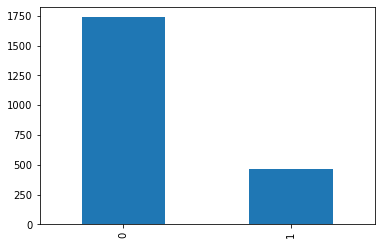

In [2]:
pd.Series(y).value_counts().plot.bar()

# Logistic Regression

In [2]:
from sklearn.linear_model import LogisticRegression


kf = KFold(n_splits=5, shuffle=True, random_state = 5645)
accs = []
sens = []
specs = []
precs = []
f1s = []

for train_index, test_index in kf.split(X):
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y[train_index]
    y_test = y[test_index]

    minmax = MinMaxScaler()
    minmax.fit(X_train[numerical])

    new_train = X_train.copy()
    new_train.loc[:, numerical] = minmax.transform(X_train[numerical])

    new_test = X_test.copy()
    new_test.loc[:, numerical] = minmax.transform(X_test[numerical])

    lrc = LogisticRegression(n_jobs = -1)
    lrc.fit(new_train, y_train)
    y_pred = lrc.predict(new_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    accs.append(accuracy_score(y_test, y_pred))
    sens.append(recall_score(y_test, y_pred))
    specs.append(tn/(tn+fp))
    precs.append(precision_score(y_test, y_pred))
    
    f1s.append(f1_score(y_test, y_pred))
    
print('Accuracy:   ', np.mean(accs), 'se:', sem(accs))
print('Sensitivity:', np.mean(sens), 'se:', sem(sens))
print('Specificity:', np.mean(specs), 'se:', sem(specs))
print('Precision:  ', np.mean(precs), 'se:', sem(precs))
print('F1:         ', np.mean(f1s), 'se: ', sem(f1s))

Accuracy: 0.8121919652101883 se: 0.005271322084893018
Sensitivity: 0.20150772950679782 se: 0.01776071586349953
Specificity: 0.9748310187889757 se: 0.005017089735839413
Precision:   0.6905881474846992 se: 0.03890912595731316
F1: 0.30806944117606827 se:  0.019118526891697844


# KNN

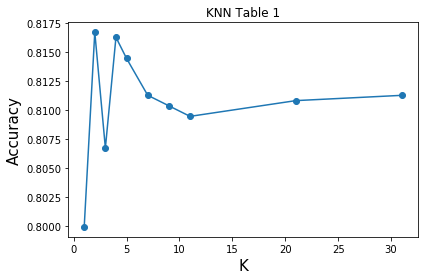

In [6]:
from sklearn.metrics import f1_score

def knn_tab_1(X, y, k):
    
    accs = []
    sens = []
    specs = []
    precs = []
    f1s = []

    kf = KFold(n_splits=5, shuffle=True, random_state = 5645)

    for train_index, test_index in kf.split(X):
        X_train = X.iloc[train_index]
        X_test = X.iloc[test_index]
        y_train = y[train_index]
        y_test = y[test_index]

        minmax = MinMaxScaler()
        minmax.fit(X_train[numerical])

        new_train = X_train.copy()
        new_train.loc[:, numerical] = minmax.transform(X_train[numerical])

        new_test = X_test.copy()
        new_test.loc[:, numerical] = minmax.transform(X_test[numerical])


        knn = KNeighborsClassifier(n_neighbors = k)
        knn.fit(new_train, y_train)
        y_pred = knn.predict(new_test)
        accs.append(accuracy_score(y_test, y_pred))
        sens.append(recall_score(y_test, y_pred))

        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        specs.append(tn/(tn+fp))
        precs.append(precision_score(y_test, y_pred))

        f1s.append(f1_score(y_test, y_pred))
        
    return np.mean(accs), sem(accs), np.mean(sens), sem(sens), np.mean(specs), sem(specs), np.mean(precs), sem(precs), np.mean(f1s), sem(f1s)

tabk = pd.DataFrame(index = ['Acc', 'St.err Acc', 'Sens', 'St.err Sens', 'Spec', 'St.err Spec', 'Prec', 'St.err Prec',
                               'F1', 'St.err F1'])
for i in [1,2,3,4,5,7,9,11,21,31]:
    tabk = pd.concat([tabk, pd.DataFrame(knn_tab_1(X,y,i), index = ['Acc', 'St.err Acc', 'Sens', 'St.err Sens', 'Spec', 'St.err Spec', 'Prec', 'St.err Prec',
                               'F1', 'St.err F1'])], axis = 1)
tabk = tabk.T.reset_index(drop = True)
tabk['K'] = pd.Series([1,2,3,4,5,7,9,11,21,31])

import matplotlib.pyplot as plt

plt.plot(tabk['K'], tabk['Acc'], '-o')
plt.xlabel('K', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.title('KNN Table 1')
plt.tight_layout()
plt.savefig('knn_table1.png')

In [45]:
print(r'''\begin{table}[]
\centering
\begin{tabular}{c||c|c|c|c}
K & Accuracy & Recall  & Specificity & F1 \\ \hline \hline''')
for i in tabk[['K', 'Acc', 'Sens', 'Spec', 'F1']].values:
    for j in i:
        if i[len(i)-1] == j:
            print(np.around(j,3), r'\\')
        elif i[0] == j:
            print(int(j), '&', end = ' ')
        else:
            print(np.around(j,4), '&', end = ' ')
        
print(r'''\end{tabular}
\end{table}''')

\begin{table}[]
\centering
\begin{tabular}{c||c|c|c|c}
K & Accuracy & Recall  & Specificity & F1 \\ \hline \hline
1 & 0.7999 & 0.5208 & 0.874 & 0.522 \\
2 & 0.8167 & 0.3115 & 0.9513 & 0.415 \\
3 & 0.8067 & 0.4454 & 0.903 & 0.491 \\
4 & 0.8163 & 0.312 & 0.9507 & 0.415 \\
5 & 0.8145 & 0.4174 & 0.9202 & 0.485 \\
7 & 0.8113 & 0.3872 & 0.9242 & 0.462 \\
9 & 0.8104 & 0.3675 & 0.9282 & 0.448 \\
11 & 0.8095 & 0.3638 & 0.9282 & 0.443 \\
21 & 0.8108 & 0.3216 & 0.9409 & 0.415 \\
31 & 0.8113 & 0.3025 & 0.9466 & 0.401 \\
\end{tabular}
\end{table}


# Random Forest

In [38]:
from sklearn.ensemble import RandomForestClassifier

accs = []
sens = []
specs = []
precs = []
f1s = []

kf = KFold(n_splits=5, shuffle=True, random_state = 5645)
for train_index, test_index in kf.split(X):
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y[train_index]
    y_test = y[test_index]

    minmax = MinMaxScaler()
    minmax.fit(X_train[numerical])

    new_train = X_train.copy()
    new_train.loc[:, numerical] = minmax.transform(X_train[numerical])

    new_test = X_test.copy()
    new_test.loc[:, numerical] = minmax.transform(X_test[numerical])
    
    
    rfc = RandomForestClassifier()
    rfc.fit(new_train, y_train)
    y_pred = rfc.predict(new_test)
    accs.append(accuracy_score(y_test, y_pred))
    sens.append(recall_score(y_test, y_pred))
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    specs.append(tn/(tn+fp))
    precs.append(precision_score(y_test, y_pred))
    
    f1s.append(f1_score(y_test, y_pred))
    
print('Accuracy:   ', np.mean(accs), 'se:', sem(accs))
print('Sensitivity:', np.mean(sens), 'se:', sem(sens))
print('Specificity:', np.mean(specs), 'se:', sem(specs))
print('Precision:  ', np.mean(precs), 'se:', sem(precs))
print('F1:         ', np.mean(f1s), 'se: ', sem(f1s))

Accuracy:    0.8285607786291157 se: 0.0060221685723021124
Sensitivity: 0.41383625249645506 se: 0.017512513441331052
Specificity: 0.9391651107048412 se: 0.007288044244821985
Precision:   0.6463856362217018 se: 0.02780615461008004
F1:          0.5022211179457249 se:  0.013764788717201916


# Simple RASAR

In [6]:
from sklearn.linear_model import LogisticRegression

def right_neighbor(neighbors, X_train, X_train_i):
    # IDX Neighbors
    idx_neigh_0 = pd.DataFrame(neighbors[1])[0].apply(lambda x: X_train_i.iloc[x].name)
    idx_neigh_1 = pd.DataFrame(neighbors[1])[1].apply(lambda x: X_train_i.iloc[x].name)
    
    idx_neigh = idx_neigh_0.copy()
    
    # dove l'indice del primo vicino risulta essere uguale a se stesso lo sostituisco con il secondo vicino
    idx_neigh[X_train.index == idx_neigh_0] = idx_neigh_1[X_train.index == idx_neigh_0].values
    
    # Distance from the Nearest Neighbor that is NOT itself
    dist_0 = pd.DataFrame(neighbors[0])[0]
    dist_1 = pd.DataFrame(neighbors[0])[1]
    
    distance = dist_0.copy()
    distance[X_train.index == idx_neigh_0] = dist_1[X_train.index == idx_neigh_0].values
    
    return idx_neigh, distance

In [7]:
accs = []
sens = []
specs = []
precs = []
f1s = []

kf = KFold(n_splits=5, shuffle=True, random_state = 5645)

for train_index, test_index in kf.split(X):
    
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y[train_index]
    y_test = y[test_index]

    minmax = MinMaxScaler()
    minmax.fit(X_train[numerical])

    new_train = X_train.copy()
    new_train.loc[:, numerical] = minmax.transform(X_train[numerical])

    new_test = X_test.copy()
    new_test.loc[:, numerical] = minmax.transform(X_test[numerical])
    
    X_train0 = X_train[y_train == 0].copy()
    X_train1 = X_train[y_train == 1].copy()

    ## DF Train

    knn0 = KNeighborsClassifier(n_neighbors = 2)
    knn0.fit(X_train0, y_train[y_train == 0])

    neigh_train0 = knn0.kneighbors(X_train, return_distance = True)
    idx_neigh0, dist0 = right_neighbor(neigh_train0, X_train, X_train0)

    knn1 = KNeighborsClassifier(n_neighbors = 2)
    knn1.fit(X_train1, y_train[y_train == 1])

    neigh_train1 = knn1.kneighbors(X_train, return_distance = True)
    idx_neigh1, dist1 = right_neighbor(neigh_train1, X_train, X_train1)

    df_rasar_train = pd.DataFrame({'idx_train': X_train.index.values,
                          'label_train': y_train,
                          'idx_neigh0': idx_neigh0.values,
                          'dist_neigh0': dist0,       
                          'idx_neigh1': idx_neigh1.values,
                          'dist_neigh1': dist1})

    # DF test
    knn0 = KNeighborsClassifier(n_neighbors = 1)
    knn0.fit(X_train0, y_train[y_train == 0])
    neigh_test0 = knn0.kneighbors(X_test, return_distance = True)
    idx_neigh_test0 = pd.DataFrame(neigh_test0[1])[0].apply(lambda x: X_train0.iloc[x].name)

    knn1 = KNeighborsClassifier(n_neighbors = 1)
    knn1.fit(X_train1, y_train[y_train == 1])
    neigh_test1 = knn1.kneighbors(X_test, return_distance = True)
    idx_neigh_test1 = pd.DataFrame(neigh_test1[1])[0].apply(lambda x: X_train1.iloc[x].name)

    df_rasar_test = pd.DataFrame({'idx_test': X_test.index.values,
                  'label_test': y_test,
                  'idx_neigh0': idx_neigh_test0.values,
                  'dist_neigh0': neigh_test0[0].ravel(),
                  'idx_neigh1': idx_neigh_test1.values,
                  'dist_neigh1': neigh_test1[0].ravel()})


    lrc = LogisticRegression()
    lrc.fit(df_rasar_train[['dist_neigh0','dist_neigh1']], y_train)
    y_pred = lrc.predict(df_rasar_test[['dist_neigh0','dist_neigh1']])
    accs.append(accuracy_score(y_test, y_pred))
    sens.append(recall_score(y_test, y_pred))
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    specs.append(tn/(tn+fp))
    precs.append(precision_score(y_test, y_pred))
    
    f1s.append(f1_score(y_test, y_pred))
    
print('Accuracy:   ', np.mean(accs), 'se:', sem(accs))
print('Sensitivity:', np.mean(sens), 'se:', sem(sens))
print('Specificity:', np.mean(specs), 'se:', sem(specs))
print('Precision:  ', np.mean(precs), 'se:', sem(precs))
print('F1:         ', np.mean(f1s), 'se: ', sem(f1s))

Accuracy:    0.8071878235659558 se: 0.007902130855140388
Sensitivity: 0.11776220360958403 se: 0.027228724768366477
Specificity: 0.9909122276029055 se: 0.005779688436644699
Precision:   0.8502742946708464 se: 0.0707112101265878
F1: 0.19786296869981665 se:  0.03769662648026407


# Simple RASAR con RF

In [9]:
from sklearn.ensemble import RandomForestClassifier

accs = []
sens = []
specs = []
precs = []
f1s = []

kf = KFold(n_splits=5, shuffle=True, random_state = 5645)

for train_index, test_index in kf.split(X):
    
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y[train_index]
    y_test = y[test_index]

    minmax = MinMaxScaler()
    minmax.fit(X_train[numerical])

    new_train = X_train.copy()
    new_train.loc[:, numerical] = minmax.transform(X_train[numerical])

    new_test = X_test.copy()
    new_test.loc[:, numerical] = minmax.transform(X_test[numerical])
    
    X_train0 = X_train[y_train == 0].copy()
    X_train1 = X_train[y_train == 1].copy()

    ## DF Train

    knn0 = KNeighborsClassifier(n_neighbors = 2)
    knn0.fit(X_train0, y_train[y_train == 0])

    neigh_train0 = knn0.kneighbors(X_train, return_distance = True)
    idx_neigh0, dist0 = right_neighbor(neigh_train0, X_train, X_train0)

    knn1 = KNeighborsClassifier(n_neighbors = 2)
    knn1.fit(X_train1, y_train[y_train == 1])

    neigh_train1 = knn1.kneighbors(X_train, return_distance = True)
    idx_neigh1, dist1 = right_neighbor(neigh_train1, X_train, X_train1)

    df_rasar_train = pd.DataFrame({'idx_train': X_train.index.values,
                          'label_train': y_train,
                          'idx_neigh0': idx_neigh0.values,
                          'dist_neigh0': dist0,       
                          'idx_neigh1': idx_neigh1.values,
                          'dist_neigh1': dist1})

    # DF test
    knn0 = KNeighborsClassifier(n_neighbors = 1)
    knn0.fit(X_train0, y_train[y_train == 0])
    neigh_test0 = knn0.kneighbors(X_test, return_distance = True)
    idx_neigh_test0 = pd.DataFrame(neigh_test0[1])[0].apply(lambda x: X_train0.iloc[x].name)

    knn1 = KNeighborsClassifier(n_neighbors = 1)
    knn1.fit(X_train1, y_train[y_train == 1])
    neigh_test1 = knn1.kneighbors(X_test, return_distance = True)
    idx_neigh_test1 = pd.DataFrame(neigh_test1[1])[0].apply(lambda x: X_train1.iloc[x].name)

    df_rasar_test = pd.DataFrame({'idx_test': X_test.index.values,
                  'label_test': y_test,
                  'idx_neigh0': idx_neigh_test0.values,
                  'dist_neigh0': neigh_test0[0].ravel(),
                  'idx_neigh1': idx_neigh_test1.values,
                  'dist_neigh1': neigh_test1[0].ravel()})


    clf = RandomForestClassifier()
    clf.fit(df_rasar_train[['dist_neigh0','dist_neigh1']], y_train)
    y_pred = clf.predict(df_rasar_test[['dist_neigh0','dist_neigh1']])
    accs.append(accuracy_score(y_test, y_pred))
    sens.append(recall_score(y_test, y_pred))
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    specs.append(tn/(tn+fp))
    precs.append(precision_score(y_test, y_pred))
    
    f1s.append(f1_score(y_test, y_pred))
    
print('Accuracy:   ', np.mean(accs), 'se:', sem(accs))
print('Sensitivity:', np.mean(sens), 'se:', sem(sens))
print('Specificity:', np.mean(specs), 'se:', sem(specs))
print('Precision:  ', np.mean(precs), 'se:', sem(precs))
print('F1:         ', np.mean(f1s), 'se: ', sem(f1s))

Accuracy:    0.7794491613170429 se: 0.010117353018028206
Sensitivity: 0.2611307492061531 se: 0.028706753973234293
Specificity: 0.917030366269256 se: 0.005301088697124177
Precision:   0.4506295739288303 se: 0.02605383872708216
F1:          0.3294599607524981 se:  0.02968803493173642
